# Credit Risk Model Exploration

In this notebook I will conuducting core data science work: going from raw data to final model.

This will involve the following:

1. Raw data exploration
2. Feature engineering
3. Model selection
4. Model optimisation

## Raw Data Exploration

Before we do anything, we need some data. As this we are doing supervised modelling here, this data will need to include labelled examples: an outcome column and features that can (hopefully) predict that outcome column.

My usual go-to for public datasets for playing around with machine learning is kaggle and UCI, with UCI being a bit more real-world/large and kaggle being more diverse.

Let's go with a credit risk dataset arbitrarily selected from kaggle: https://www.kaggle.com/datasets/laotse/credit-risk-dataset

This is a dataset that contains loan attributes with the target variable being if the loan defaulted or not (0 for non-default, 1 for default). Note that this data isn't strictly real, but that's ok for our purposes.

### Clean Data Checks

Before assessing the attributes of the data, it's good to make sure that the data is clean. Otherwise we're going to have modelling problems later.

#### Clean data real world side note

In the real world, one of the biggest challenges is collecting clean data to use. This has been skipped here for reasons of brevity and personal sanity.

Also, in my view clean data isn't the responsibility of the modeller (size of org dependent). Identifying defects, yes. Collaborating with others to fix these defects, sure. But ultimately the responsibility is shared between those collating/maintaining the data.

Note too that in the real world, the first step in a project might be setting up the pipelines. That's truly end-to-end. In this type of project, the modelling component - which we are focusing on here - plays a minor part in the process as a whole.

#### Import data and have a look at what we have

In [1]:
# Import pandas to read csv
import pandas as pd

In [4]:
# Read csv using pandas
raw_data = pd.read_csv("credit_risk_dataset.csv")

In [5]:
# Initial look just for fun
raw_data.head(5)

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

Target column is *loan_status*.

In [7]:
len(raw_data.columns)

12

12 - 1 = 11 features to try and predict this target column.

#### How complete are the columns?

In [8]:
# Import missingno
import missingno as msno

In [10]:
# Matplotlib inline to materialise visualisations in notebook 
%matplotlib inline

<Axes: >

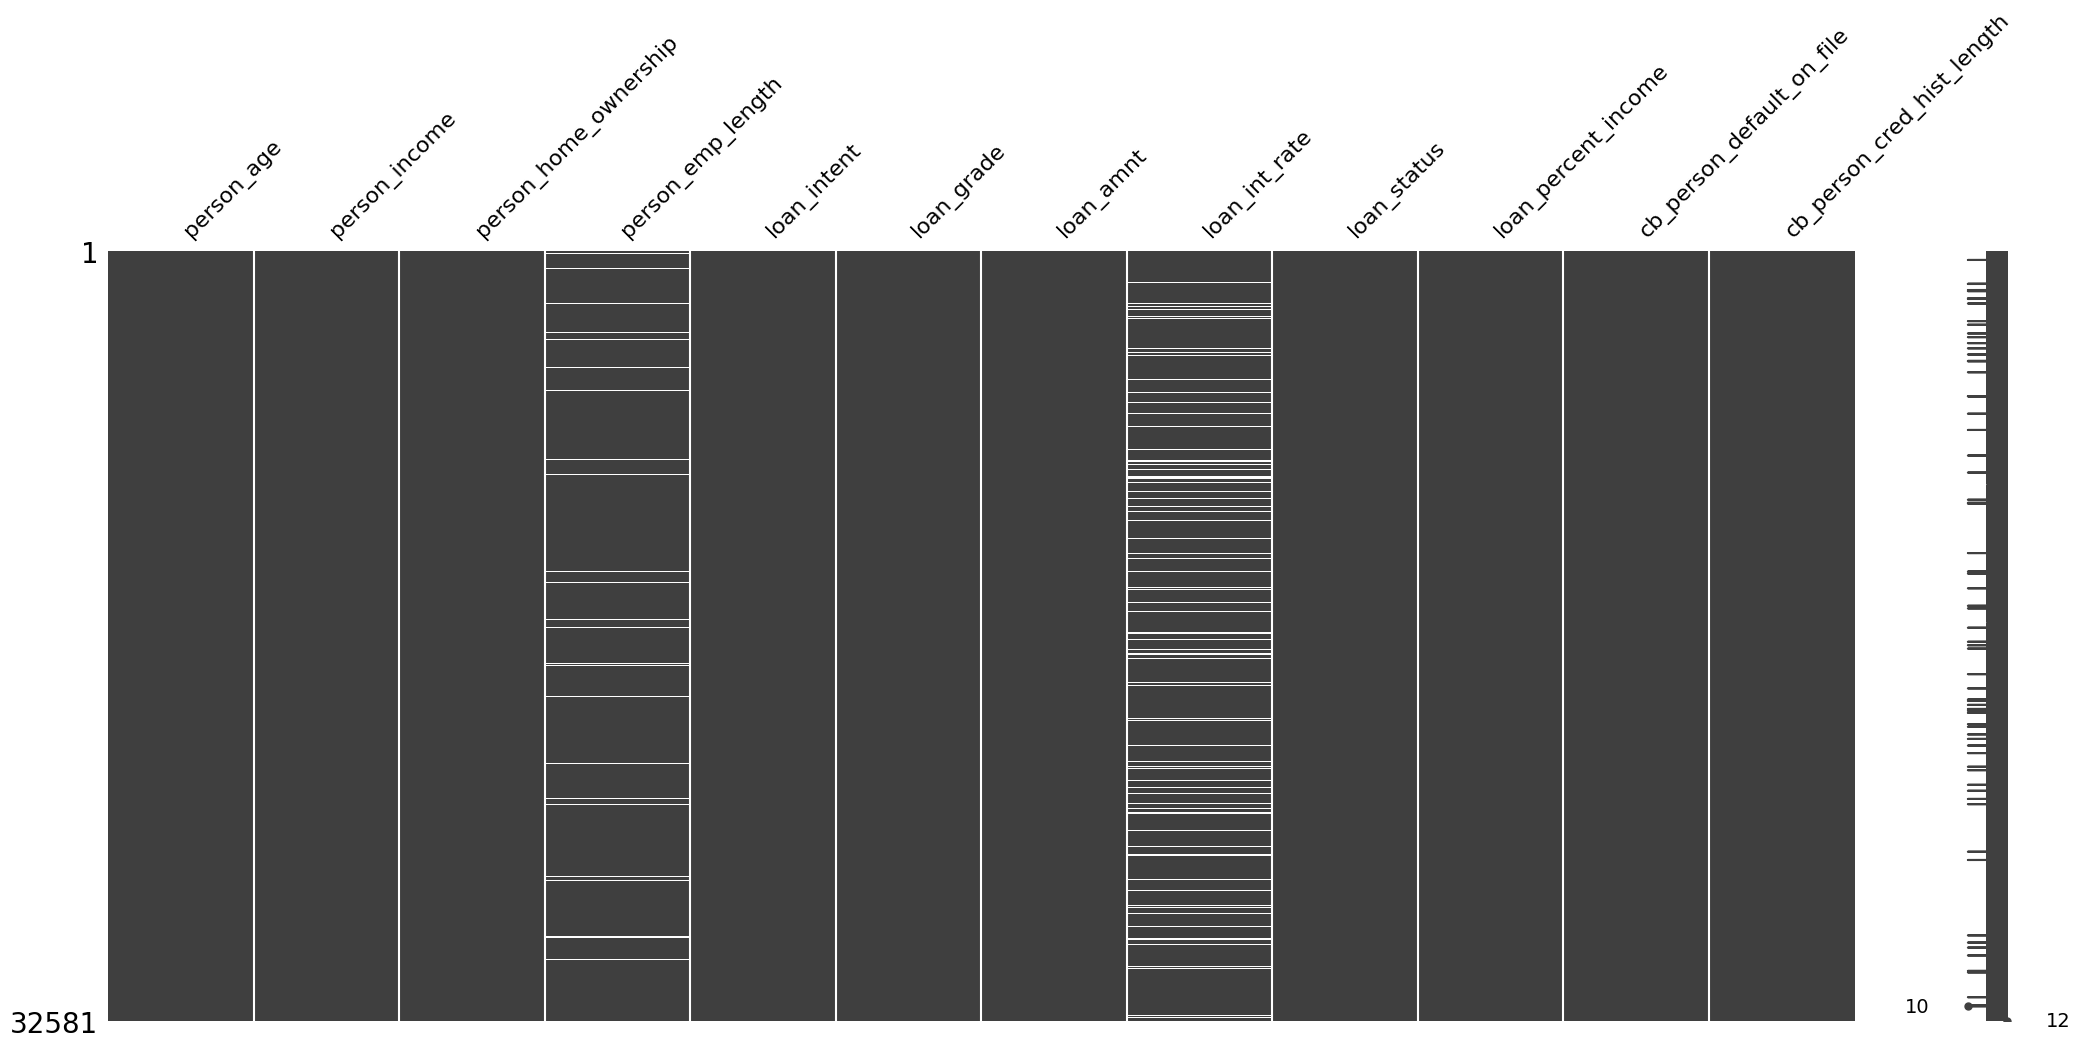

In [11]:
# Creating null matrix
msno.matrix(raw_data)

Target column is complete, which is nice, as are most of our features. We'll deal with nulls in the feature engineering stage.

#### Is the data of good quality?

First thing to do is check type consistency.

The easiest way to do this is using pandas dtypes. A column containing multiple types will be assigned the type 'object'.

In [13]:
# Checking types using pandas
raw_data.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

Let's drill down into the 'object' features.

In [32]:
[raw_data[col].value_counts() for col in raw_data.columns if raw_data[col].dtype == 'object']  

[person_home_ownership
 RENT        16446
 MORTGAGE    13444
 OWN          2584
 OTHER         107
 Name: count, dtype: int64,
 loan_intent
 EDUCATION            6453
 MEDICAL              6071
 VENTURE              5719
 PERSONAL             5521
 DEBTCONSOLIDATION    5212
 HOMEIMPROVEMENT      3605
 Name: count, dtype: int64,
 loan_grade
 A    10777
 B    10451
 C     6458
 D     3626
 E      964
 F      241
 G       64
 Name: count, dtype: int64,
 cb_person_default_on_file
 N    26836
 Y     5745
 Name: count, dtype: int64]

Seems fine. Just all categorical columns. We'll leave these for now.

Next we need to have a look at the numerical columns to make sure everything's in order.

In [35]:
# Summary statistics
raw_data.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.470000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                32581.000000  
mean                     5.804211  
std                      4.055001  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

Ok there seem to be some problems here. I hope someone hasn't been employed for 123 years, for example.

Is this one row or are there multiple problems?

In [36]:
raw_data[raw_data.person_age == 144]

person_age  person_income person_home_ownership  person_emp_length  \
81            144         250000                  RENT                4.0   
183           144         200000              MORTGAGE                4.0   
32297         144        6000000              MORTGAGE               12.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
81        VENTURE          C       4800          13.57            0   
183     EDUCATION          B       6000          11.86            0   
32297    PERSONAL          C       5000          12.73            0   

       loan_percent_income cb_person_default_on_file  \
81                    0.02                         N   
183                   0.03                         N   
32297                 0.00                         N   

       cb_person_cred_hist_length  
81                              3  
183                             2  
32297                          25

In [37]:
raw_data[raw_data.person_emp_length == 123]

person_age  person_income person_home_ownership  person_emp_length  \
0            22          59000                  RENT              123.0   
210          21         192000              MORTGAGE              123.0   

    loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0      PERSONAL          D      35000          16.02            1   
210     VENTURE          A      20000           6.54            0   

     loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                   0.59                         Y                           3  
210                 0.10                         N                           4

Multiple records...let's visualise to see if these types of things are outliers or simply the right end of the distribution.

In [41]:
# Import seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

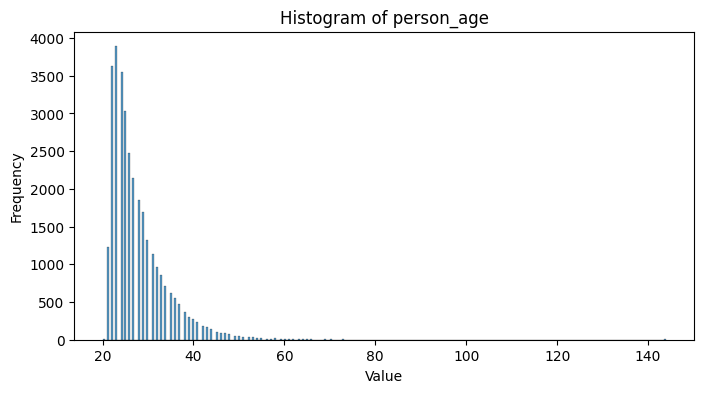

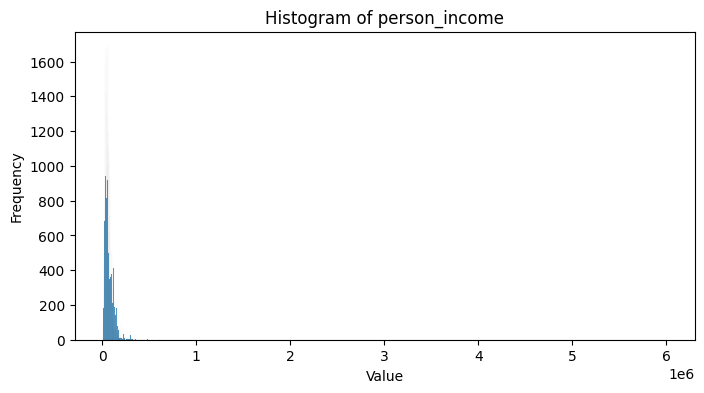

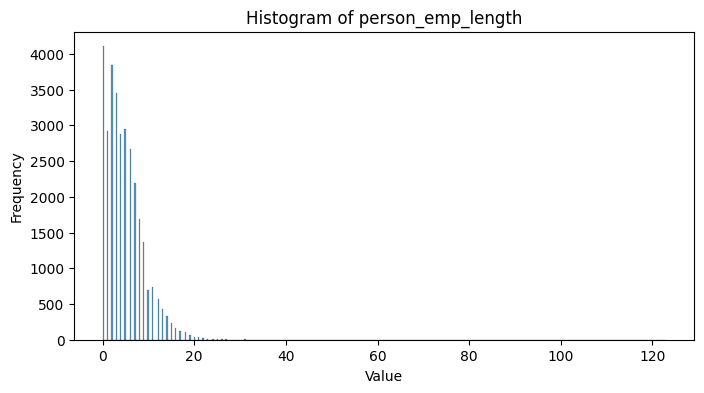

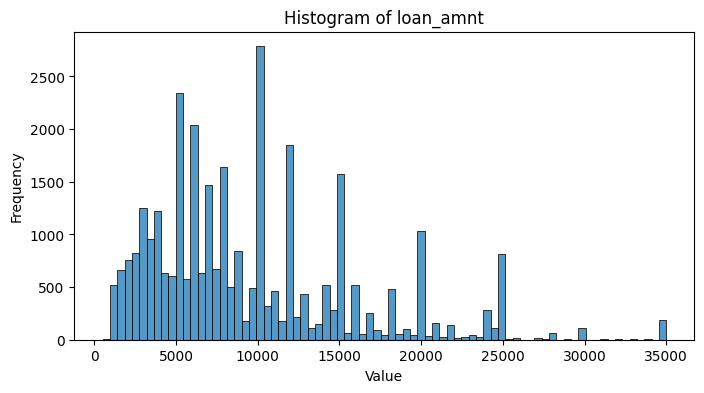

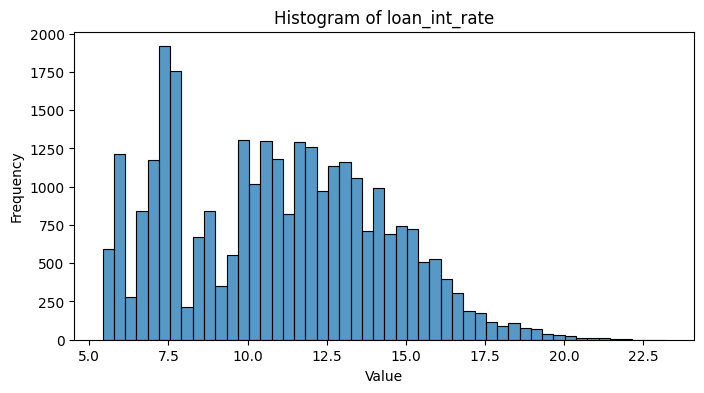

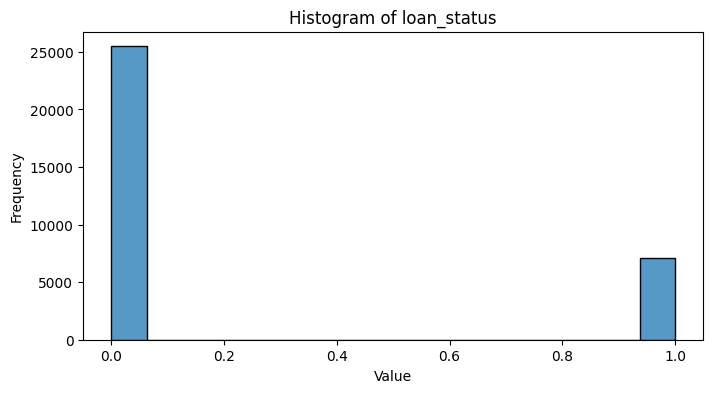

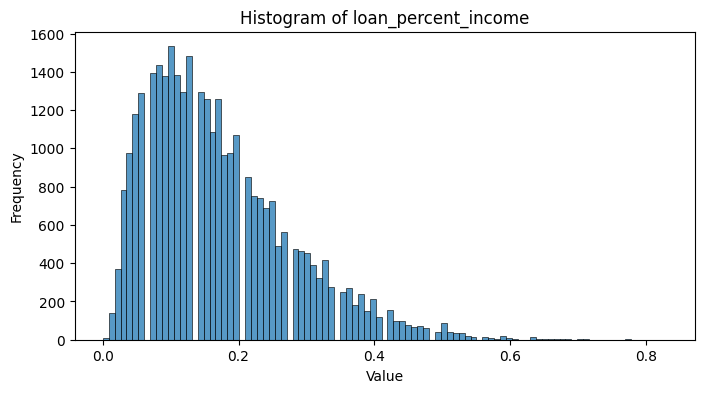

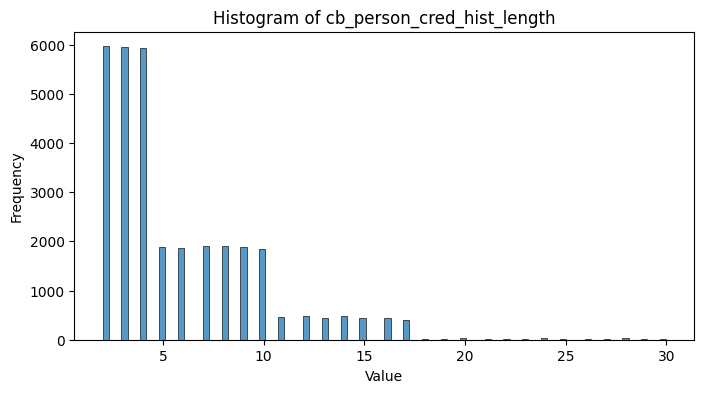

In [44]:
# Get numerical columns to plot
num_cols = [col for col in raw_data.columns if raw_data[col].dtype != 'object']

for column in num_cols:
    plt.figure(figsize=(8, 4))  # Set the size of each subplot
    sns.histplot(raw_data[column], kde=False)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

Ok so looks like we have some outliers, which need to be removed.

#### Outlier real world side note

Note that in the real world the way I would actually deal with these outliers is by talking to the relevant stakeholers. These can either be caused with some type of ETL malfunction, or bad/incorrect input data. Here, we don't have the luxury of doing that so we sort of have to guess.

You can also use ground truth, specifically here the laws of the universe. And common sense. Here we have a good example with age: the oldest person ever recorded was 122 years old. So I suspect 144 as we have here is incorrect.

Income is more interesting - here we have a value that appears to be an outlier. But it is possible. If we zoom out and think about the broader picture, it doesn't really matter. This data point could f*ck up our model, so we'll remove it. We must however be careful to consider what happens in production when either a true or false outlier enters the inference pipeline. There should be either pre or post inference checks to handle this. Ideally both.

## Feature Engineering

Model prep feature transformation TODO:

1. Remove outliers
2. Deal with nulls
3. Add/remove features
4. ML transformations

#### Model creation process real world side note

Sometimes the process outlined here both in this section and others isn't linear.

These processes are sometimes inter-dependent. How I deal with nulls can depend on model selection, production requirements can influence what model I select, the data pipeline can dictate what features I add/remove, etc.

For the purposes of illustration I will try and keep it linear.

Image source: https://sherbold.github.io/intro-to-data-science/02_Process.html

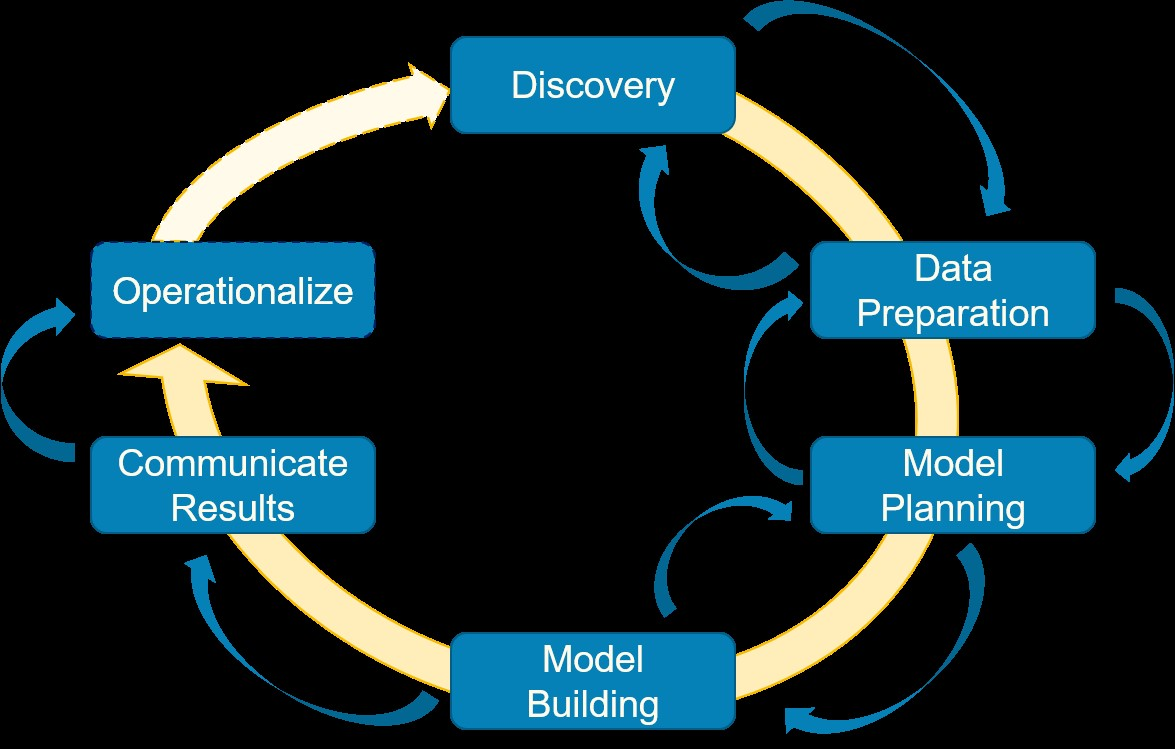

#### Remove outliers

We have small number of outliers in a few columns. Without domain knowledge we have to sort of guess what the bounds for these are and remove the rows which contain values above this bounding point. We do this by observing the histograms above. We could also do this mathematically using summary statistics.

In [52]:
# Setting outlier bounds
outlier_bound_dict = {
    'person_age_bound': 80,
    'person_income_bound': 1000000,
    'person_emp_length_bound': 40
}

In [ ]:
# Find match in columns
# Find rows with value above bound
# remove those rows from df

In [86]:
# Get df to transform
no_out_df = raw_data

In [87]:
# Remove values above upper bounds
for bound_key in outlier_bound_dict.keys():
    no_out_df = no_out_df[no_out_df[bound_key[:-6]] < outlier_bound_dict[bound_key]]

In [88]:
# Check outliers removed
no_out_df.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  31667.000000   31667.000000       31667.000000  31667.000000   
mean      27.719077   66125.154514           4.780623   9660.677519   
std        6.173349   47212.325572           4.029423   6335.156923   
min       20.000000    4000.000000           0.000000    500.000000   
25%       23.000000   39326.000000           2.000000   5000.000000   
50%       26.000000   56000.000000           4.000000   8000.000000   
75%       30.000000   80000.000000           7.000000  12500.000000   
max       76.000000  948000.000000          38.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   28623.000000  31667.000000         31667.000000   
mean       11.040291      0.215524             0.169656   
std         3.229408      0.411192             0.106252   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.480000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                31667.000000  
mean                     5.804023  
std                      4.049720  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

#### Deal with nulls

In [89]:
no_out_df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length                0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3044
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [90]:
len(no_out_df)

31667

There is a semi-complicated question of how to deal with these, involving multiple factors.

I could just remove the columns containing them. I'm not going to do that as the % of nulls is small and we don't have many feature columns here. Given lack of domain knowledge, and looking at the distributions, it seems like the best thing to do is impute. We don't have many rows to work with :(

As far as how to impute there are again multiple ways to do this. We could try and predict the missing values, see if they relate to a gap in the dataset, etc. Here we just use mean value. Note we must do this *after* removing outliers. 

In [98]:
# Copy no outlier df
no_null_df = no_out_df

In [99]:
# Fill nulls of loan_int_rate with the mean
no_null_df['loan_int_rate'].fillna(no_null_df['loan_int_rate'].mean(), inplace=True)

In [100]:
# Check it worked
no_null_df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [104]:
# Check means are the same
no_out_df['loan_int_rate'].mean() == no_null_df['loan_int_rate'].mean()

True

#### Adding and removing features

Personally, I only tend to remove features that have obviously no affect on the target feature to de-clutter the dataset a bit. I tend to let regularisation take care of superfluous features rather than apply qualitative and quantitative dimensionality reduction before the modelling stage.

Although let's have a look at correlation anyway.

In [124]:
# Copy the df as always
add_feat_df = no_null_df

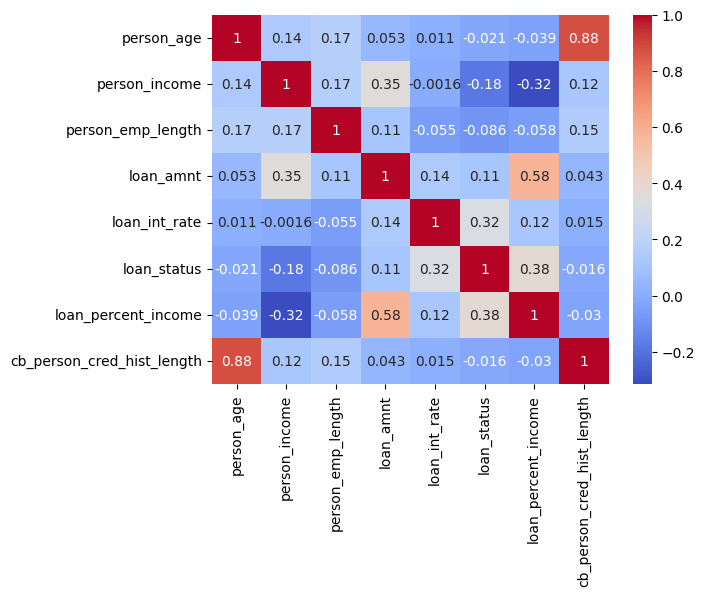

In [115]:
# Creating correlation heatmap of numerical columns
sns.heatmap(add_feat_df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.show()

Adding features in my view should come primarily from domain knowledge. We actually already have one already: *loan_percent_income* is equal to *loan_amount* / *person_income*. Although we don't have a lot of that here, we can add one just for fun.

I want to create a personal stability feature. My hypothesis is that this is dependent on age and employment length. Older people and people who stay at their jobs longer are more likely to be reliable.

In [125]:
# Creating stability feature called person_age_and_emp_length
add_feat_df['person_age_and_emp_length'] = add_feat_df['person_age'] * add_feat_df['person_emp_length']

In [127]:
# Checking new column
add_feat_df['person_age_and_emp_length']

1        105.0
2         25.0
3         92.0
4        192.0
5         42.0
         ...  
32576     57.0
32577    216.0
32578    195.0
32579    280.0
32580    132.0
Name: person_age_and_emp_length, Length: 31667, dtype: float64

Ok now we have our final list of features ready to be transformed for modelling.

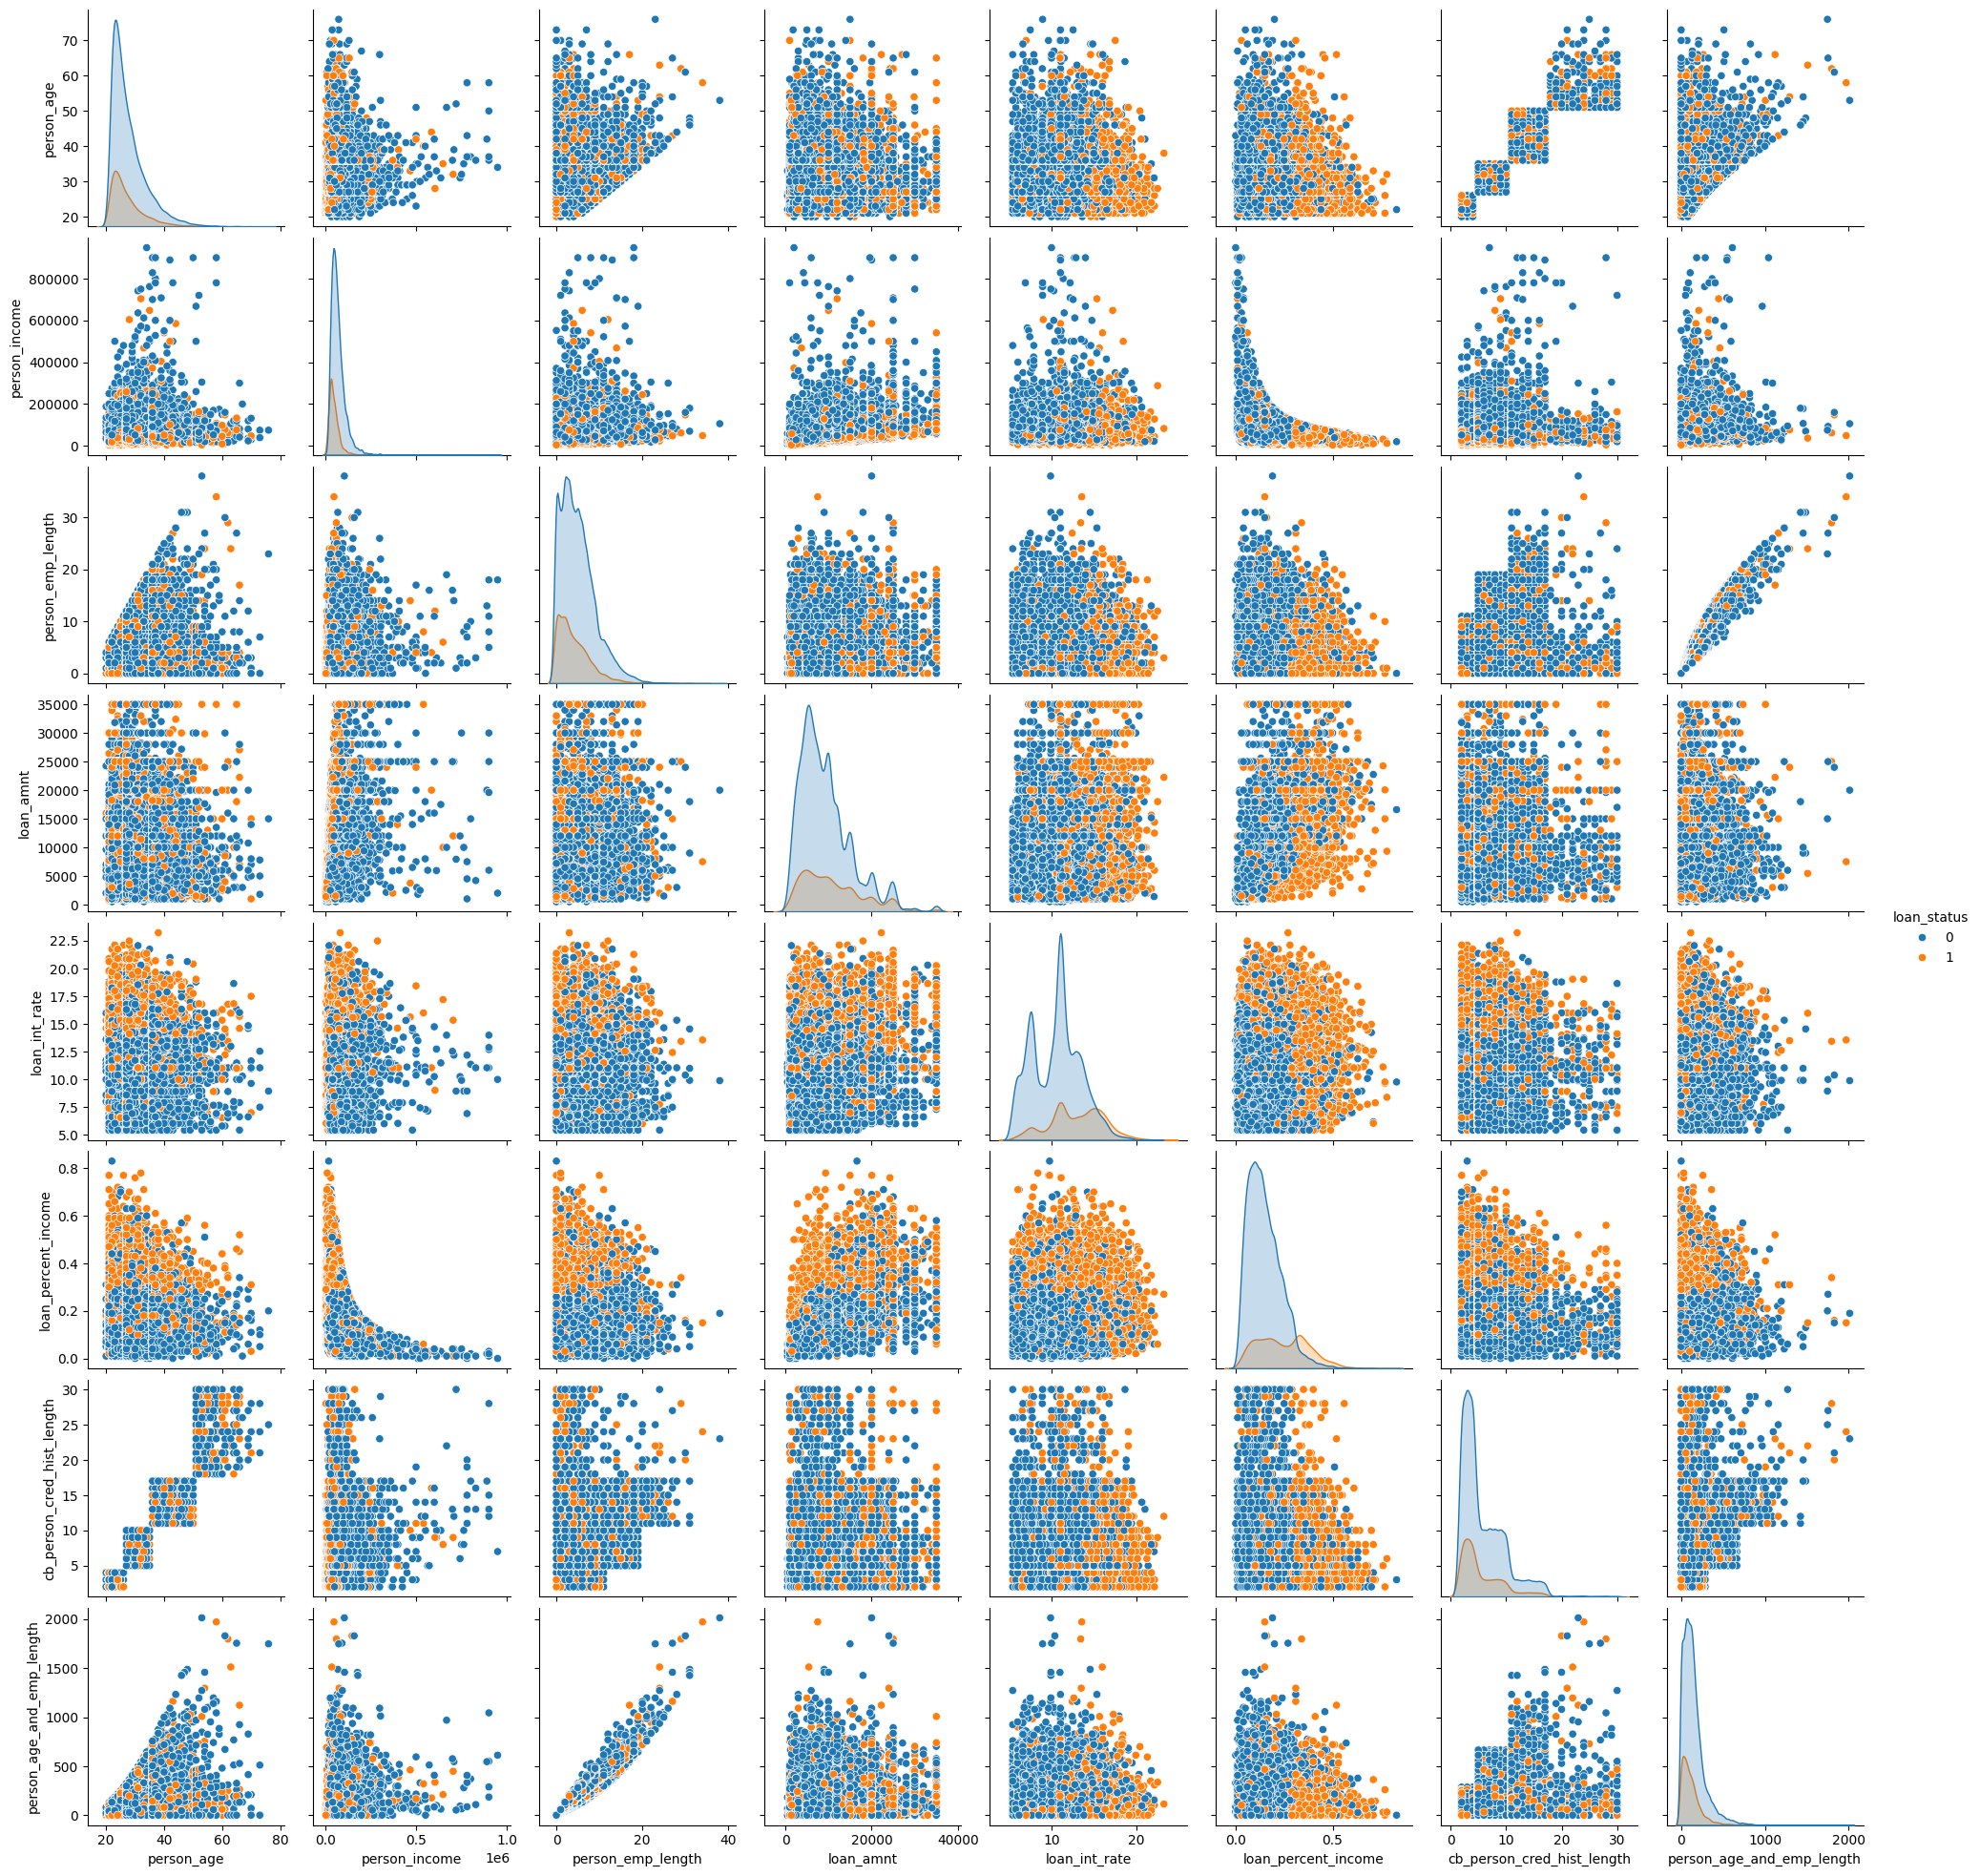

In [128]:
# sns pairplot to see relationshipm with target feature just for fun
sns.pairplot(add_feat_df, hue='loan_status')

#### ML transformations

Random notes:

- No time element in this dataset --> splitting the dataset
- Real world development process: disco, MVP model, etc.
- Ongoing validation after deployment